# 3주차. 심층 신경망 훈련 1 : 모델 정의
## 11. 심층 신경망 훈련하기

In [1]:
import numpy as np
import os

import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Gradient 소실 및 폭주

1. Vanishing gradient : gradient가 더 이상 커지지 않고 0으로 수렴 -> 변화X -> 모델 최적화X
2. Exploding gradient : 파라미터들이 무한대로 폭주  

그래디언트에 문제가 생기면 모델을 정의하는 파라미터들을 훈련하는데 문제가 생긴다.  

**심층 신경망 훈련할 때 발생하는 문제**  
- 까다로운 그레이디언트 소실 또는 그레이디언트 폭주 문제  
심층 신경망의 아래쪽으로 갈수록 그레이디언트가 점점 더 작아지거나 커지는 현상  
- 대규모 신경망을 위한 훈련 데이터가 충분하지 않거나 레이블을 만드는 작업에 비용이 너무 많이 든다.
- 훈련이 극단적으로 느려질 수 있다.
- 수백만 개의 파라미터를 가진 모델은 훈련 세트에 과대적합될 위험이 매우 크다.  
특히 훈련 샘플이 충분하지 않거나 잡음이 많은 경우에 그렇다.

**기존 방식의 문제**  
- Logistic sigmoid activation function
- Zero mean and unit variance initialization (평균 0, 표준편차 1)
- 위 이유 때문에 각 layer에서 input과 output의 variance 차이 발생
- 위쪽 layer의 output은 0이나 1로 수렴하여 gradient의 크기가 작음
- Backpropagation을 거듭하며 더욱 약해짐
- **각 layer의 input과 output의 variance 차이를 줄이는 방식으로 해결**

In [2]:
def logit(z):
    return 1 / (1 + np.exp(-z))

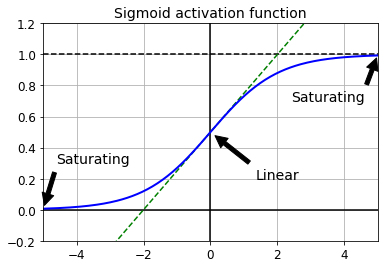

In [3]:
# 로지스틱 활성화 함수
z = np.linspace(-5, 5, 200)

plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [1, 1], 'k--')
plt.plot([0, 0], [-0.2, 1.2], 'k-')
plt.plot([-5, 5], [-3/4, 7/4], 'g--')
plt.plot(z, logit(z), "b-", linewidth=2)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Saturating', xytext=(3.5, 0.7), xy=(5, 1), arrowprops=props, fontsize=14, ha="center")
plt.annotate('Saturating', xytext=(-3.5, 0.3), xy=(-5, 0), arrowprops=props, fontsize=14, ha="center")
plt.annotate('Linear', xytext=(2, 0.2), xy=(0, 0.5), arrowprops=props, fontsize=14, ha="center")
plt.grid(True)
plt.title("Sigmoid activation function", fontsize=14)
plt.axis([-5, 5, -0.2, 1.2])

plt.show()

# 초기화 설정

**Glorot initialization(글로럿 초기화)**  
평균이 0이고 분산이 1/fan_avg^2인 정규분포 ( 유닛의 개수가 커지면 분산이 작아짐)  
fan_in(팬-인) : 사실층의 입력, fan_out(팬-아웃) : 사실 층의 출력  
fan_avg = (fan_in + fan_out) / 2 (레이어의 개수 평균)

**He 혹은 LeCun initialization도 비슷한 방식**  
초기화 전략 - 활성화 함수 - 정규분포(분산정의)  
- 글로럿 - 활성화 함수 없음. 하이퍼볼릭 탄젠트, 로지스틱, 소프트맥스 - 1/fan_avg  
- He - ReLU 함수와 그 변종들 - 2/fan_in
- 르쿤 - SELU - 1/fan_in

In [4]:
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

In [5]:
# 케라스는 기본적으로 균등분포의 글로럿 초기화를 사용
# kernel_initializer="he_uniform" 이나 kernel_initializer="he_normal"로 바꾸어 He 초기화 사용
keras.layers.Dense(10, activation="relu", kernel_initializer="he_normal")

In [6]:
# Variance Scaling
# 새로 만들기, 객체를 생성해서 만들 수 있다.
he_avg_init = keras.initializers.VarianceScaling(scale=2., mode='fan_avg',
                                          distribution='uniform')
keras.layers.Dense(10, activation="relu", kernel_initializer=he_avg_init)

# Activation function

**ReLU**  
장점  
- 계산이 단순하고 0보다 클 때 수렴하지 않아서 gradient 역전파에 유리  

단점  
- 0보다 작은 영역에서 gradient가 사라지는 문제로 인해 뉴런이 죽는 경우가 많음  

RReLU(random ReLU) : 훈련하는 동안 주어진 범위에서 α를 무작위로 선택하고 테스트시에는 평균을 사용  
PReLU(parametric ReLU) : α가 훈련되는 동안 학습

In [7]:
def leaky_relu(z, alpha=0.01):
    return np.maximum(alpha*z, z)

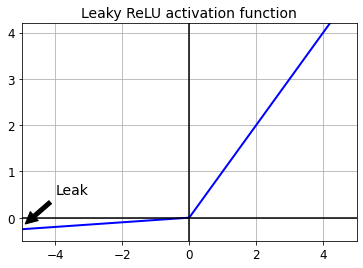

In [8]:
plt.plot(z, leaky_relu(z, 0.05), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([0, 0], [-0.5, 4.2], 'k-')
plt.grid(True)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Leak', xytext=(-3.5, 0.5), xy=(-5, -0.2), arrowprops=props, fontsize=14, ha="center")
plt.title("Leaky ReLU activation function", fontsize=14)
plt.axis([-5, 5, -0.5, 4.2])

plt.show()

LeakyReLU : ReLU와 비슷하지만 음수 분분이 작은 기울기를 가진다.

**ELU(exponential LU)**  
훈련시간이 줄고 신경망의 테스트 세트 성능도 더 높았다.

ELU 함수는 몇 가지를 제외하고는 ReLU와 매우 비슷  
- z < 0일 때 음숫값이 들어오므로 활성화 함수의 평균 출력이 0에 더 가까워진다.  
이는 그레이디언트 소실 문제를 완화해준다.  
- z < 0이어도 그레이디언트가 0이 아니므로 죽은 뉴런을 만들지 않는다.
- a = 1이면 이 함수는 z = 0에서 급격히 변동하지 않으므로 z = 0을 포함해 모든 구간에서 매끄러워 경사 하강법의 속도를 높여준다.
  

- ELU 활성화 함수의 주요 단접은 (지수 함수를 사용하므로) ReLU나 그 변종들보다 계산이 느리다

In [9]:
# ELU 활성화 함수
def elu(z, alpha=1):
    return np.where(z < 0, alpha * (np.exp(z) - 1), z)

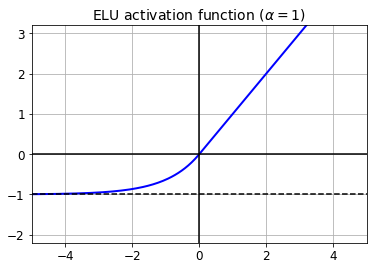

In [10]:
plt.plot(z, elu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1, -1], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title(r"ELU activation function ($\alpha=1$)", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])

plt.show()

**SELU(scaled ELU)**  
스케일이 조정된 ELU 활성화 함수의 변종  
- a = 1.67인 ELU에 1.05를 곱한 함수
- 훈련 중에 각 layer의 output이 zero mean과 unit variance 표준화가 되도록 self-normalization 효과
- 조건이 충족되어야 한다.
1. input이 표준화 되어 있어야 한다.
2. LeCun 정규분포 initializaeion되어 있어야 함
3. 시퀀셜 구조의 fully connected layer로 구성(혹은 CNN)

In [11]:
# SELU 활성화 함수
from scipy.special import erfc

# alpha와 scale은 평균 0과 표준 편차 1로 자기 정규화합니다
alpha_0_1 = -np.sqrt(2 / np.pi) / (erfc(1/np.sqrt(2)) * np.exp(1/2) - 1)
scale_0_1 = (1 - erfc(1 / np.sqrt(2)) * np.sqrt(np.e)) * np.sqrt(2 * np.pi) * (2 * erfc(np.sqrt(2))*np.e**2 + np.pi*erfc(1/np.sqrt(2))**2*np.e - 2*(2+np.pi)*erfc(1/np.sqrt(2))*np.sqrt(np.e)+np.pi+2)**(-1/2)

In [12]:
def selu(z, scale=scale_0_1, alpha=alpha_0_1):
    return scale * elu(z, alpha)

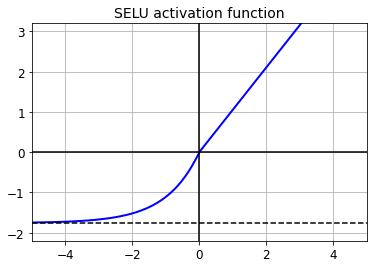

In [13]:
plt.plot(z, selu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1.758, -1.758], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title("SELU activation function", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])

plt.show()

**선택 기준 예시**  
SELU > ELU > LeakyReLU 등 > ReLU > tanh > logistic (항상 그렇지는 않다.)  
시간과 자원이 충분하다면 교차 검증을 통해 평가  
Over-fitting의 경우는 RreLU, 훈련세트가 아주 크다면 PReLU, 속도가 중요하다면 ReLU

In [14]:
# LeakyReLU 활성화 함수 사용하려면 LeakyReLU 층을 만들고
# 모델에서 적용하려는 층 뒤에 추가

In [15]:
# SELU 활성화 함수를 사용하려면 층을 만들 때
# activation="selu"와 kernerl_initializer="lecun_normal"로 지정
keras.layers.Dense(10, activation="selu",
                   kernel_initializer="lecun_normal")

# Batch normalization(BN, 배치 정규화)

- 각 층에서 활성화 함수를 통과하기 전이나 후에 모델에 연산을 하나 추가한다.  
- input 데이터를 정규화한 뒤, 그 결과값을 스케일링하고 이동  
- 입력 데이터를 원점에 맞추고 정규화하려면 알고리즘은 평균과 표준편차를 추정해야 한다.  
- 이를 위해 현재 미니배치에서 입력의 평균과 표준편차를 평가한다.  
- 훈련하는 동안 배치 정규화는 입력을 정규화한 다음 스케일을 조정하고 이동시킨다.
- 훈련된 파라미터를 사후에 병합하여 복잡도 감소
- 훈련 단계와 테스트 단계의 동작을 다르게 함.

**배치 정규화 효과**  
- Vanishing gradient 문제를 크게 완화(주된 목적을 제일 잘 해결)
- Tanh 혹은 logistic activation function 사용 가능
- Initialization에 덜 민감 (덜 민감해지면서 다른 형태의 activation function 사용이 가능)
- 모델 복잡도 증가에도 불구하고 학습 속도 높임
- Regularization(규제)에 기여

In [16]:
# 케라스로 배치 정규화 구현하기
# 은닉층의 활성화 함수 전이나 후에 BatchNormalization 층을 추가

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(10, activation="softmax")
])

In [17]:
model.summary()

# 784 * 4 = 3136

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 784)               3136      
_________________________________________________________________
dense_3 (Dense)              (None, 300)               235500    
_________________________________________________________________
batch_normalization_1 (Batch (None, 300)               1200      
_________________________________________________________________
dense_4 (Dense)              (None, 100)               30100     
_________________________________________________________________
batch_normalization_2 (Batch (None, 100)               400       
_________________________________________________________________
dense_5 (Dense)              (None, 10)                1

In [18]:
bn1 = model.layers[1]
[(var.name, var.trainable) for var in bn1.variables]

# gamma, beta : 역전파로 훈련
# moving_mean, moving_variance : 훈련X, 얻어지는 연산 결과를 가지고 통계를 내는 파라미터, 다른 연산에 의해 업데이트


[('batch_normalization/gamma:0', True),
 ('batch_normalization/beta:0', True),
 ('batch_normalization/moving_mean:0', False),
 ('batch_normalization/moving_variance:0', False)]

In [19]:
# Activation function 이전에 BN 추가
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(300, use_bias=False),
    keras.layers.BatchNormalization(),
    keras.layers.Activation("relu"),
    keras.layers.Dense(100, use_bias=False),
    keras.layers.BatchNormalization(),
    keras.layers.Activation("relu"),
    keras.layers.Dense(10, activation="softmax")
])

- Batch Normalization(BN)
- Weight Normalization(WN)
- Layer Normalization(LN)

# Gradient clipping(폭주)

RNN과 같이 BN을 적용하기 어려운 경우에 시도

In [20]:
# 케라스에서 그레이디언트 클리핑 구현
# 옵티마이저를 만들 때 clipvalue와 clipnorm 매개변수를 지정하면 된다.
optimizer = keras.optimizers.SGD(clipvalue=1.0)
optimizer = keras.optimizers.SGD(clipnorm=1.0)

# Pre-trained Layer 재사용

**전이 학습(transfer learning)**  
아주 큰 규모의 DNN을 처음부터 새로 훈련하는 것이 아니라 해결하려는 것과 비슷한 유형의 문제를 처리한 신경망을 찾아본다.  
있다면 그 신경망의 하위층을 재사용하는 것이 좋다.  
이 방법은 훈련 속도를 크게 높일 뿐만 아니라 필요한 훈련 데이터도 크게 줄여준다.

* 얼굴 인식 시스템 구현  
  - 무작위로 많은 인물의 이미지를 수집
  - 두 개의 다른 이미지가 같은 사람인지 판별하는 신경망 훈련
  - 하위 layer를 재사용해서 목적하는 얼굴을 잘 구분하는 분류기 훈련

* 자연어 처리
  - 널리 알려진 말뭉치 corpus 확보
  - 일부 단어를 일부러 누락한 데이터를 생성하여 예측 모델 훈련
  - 모델을 재사용하여 필요한 목적에 맞게 세부 튜닝

In [21]:
# 케라스를 사용한 전이 학습
# 8개의 클래스만 담겨 있는 패션 MNIS 데이터셋

# 작업 A : 샌들과 셔츠를 제외한 다른 클래스를 분류하는 작업  
# 모델 A : 작업 A를 해결하는 모델
# 작업 B : 샌들과 셔츠 이미지를 구분하는 작업(양성 = 셔츠, 음성 = 샌들)
# 모델 B : 작업 B를 해결하기 위해 이진분류기 훈련한 모델 A와 비슷한 모델

In [22]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full / 255.0
X_test = X_test / 255.0
X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

4431872/4422102 [==============================] - 0s 0us/step


In [23]:
def split_dataset(X, y):
    y_5_or_6 = (y == 5) | (y == 6) # sandals or shirts
    y_A = y[~y_5_or_6]
    y_A[y_A > 6] -= 2 # class indices 7, 8, 9 should be moved to 5, 6, 7
    y_B = (y[y_5_or_6] == 6).astype(np.float32) # binary classification task: is it a shirt (class 6)?
    return ((X[~y_5_or_6], y_A),
            (X[y_5_or_6], y_B))

(X_train_A, y_train_A), (X_train_B, y_train_B) = split_dataset(X_train, y_train)
(X_valid_A, y_valid_A), (X_valid_B, y_valid_B) = split_dataset(X_valid, y_valid)
(X_test_A, y_test_A), (X_test_B, y_test_B) = split_dataset(X_test, y_test)
X_train_B = X_train_B[:200]
y_train_B = y_train_B[:200]

In [24]:
X_train_A.shape

(43986, 28, 28)

In [25]:
X_train_B.shape

(200, 28, 28)

In [26]:
tf.random.set_seed(42)
np.random.seed(42)

In [27]:
model_A = keras.models.Sequential()
model_A.add(keras.layers.Flatten(input_shape=[28, 28]))
for n_hidden in (300, 100, 50, 50, 50):
    model_A.add(keras.layers.Dense(n_hidden, activation="selu"))
model_A.add(keras.layers.Dense(8, activation="softmax"))

model_A.compile(loss="sparse_categorical_crossentropy",
                optimizer=keras.optimizers.SGD(lr=1e-3),
                metrics=["accuracy"])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [28]:
history = model_A.fit(X_train_A, y_train_A, epochs=20,
                    validation_data=(X_valid_A, y_valid_A))

Epoch 1/20
1375/1375 [==============================] - 10s 7ms/step - loss: 0.5927 - accuracy: 0.8104 - val_loss: 0.3896 - val_accuracy: 0.8667
Epoch 2/20
1375/1375 [==============================] - 5s 4ms/step - loss: 0.3523 - accuracy: 0.8786 - val_loss: 0.3289 - val_accuracy: 0.8824
Epoch 3/20
1375/1375 [==============================] - 6s 5ms/step - loss: 0.3170 - accuracy: 0.8896 - val_loss: 0.3014 - val_accuracy: 0.8989
Epoch 4/20
1375/1375 [==============================] - 5s 3ms/step - loss: 0.2973 - accuracy: 0.8975 - val_loss: 0.2894 - val_accuracy: 0.9021
Epoch 5/20
1375/1375 [==============================] - 5s 4ms/step - loss: 0.2835 - accuracy: 0.9022 - val_loss: 0.2776 - val_accuracy: 0.9066
Epoch 6/20
1375/1375 [==============================] - 4s 3ms/step - loss: 0.2729 - accuracy: 0.9061 - val_loss: 0.2735 - val_accuracy: 0.9071
Epoch 7/20
1375/1375 [==============================] - 4s 3ms/step - loss: 0.2641 - accuracy: 0.9093 - val_loss: 0.2720 - val_accuracy

In [29]:
model_A.save("my_model_A.h5")

In [30]:
# 모델 A와 구조가 거의 비슷한 모델 B 만듦

model_B = keras.models.Sequential()
model_B.add(keras.layers.Flatten(input_shape=[28, 28]))
for n_hidden in (300, 100, 50, 50, 50):
    model_B.add(keras.layers.Dense(n_hidden, activation="selu"))
model_B.add(keras.layers.Dense(1, activation="sigmoid"))

model_B.compile(loss="binary_crossentropy",
                optimizer=keras.optimizers.SGD(lr=1e-3),
                metrics=["accuracy"])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [31]:
history = model_B.fit(X_train_B, y_train_B, epochs=20,
                      validation_data=(X_valid_B, y_valid_B))

Epoch 1/20
7/7 [==============================] - 1s 40ms/step - loss: 0.9573 - accuracy: 0.4650 - val_loss: 0.6314 - val_accuracy: 0.6004
Epoch 2/20
7/7 [==============================] - 0s 15ms/step - loss: 0.5692 - accuracy: 0.7450 - val_loss: 0.4784 - val_accuracy: 0.8529
Epoch 3/20
7/7 [==============================] - 0s 14ms/step - loss: 0.4503 - accuracy: 0.8650 - val_loss: 0.4102 - val_accuracy: 0.8945
Epoch 4/20
7/7 [==============================] - 0s 17ms/step - loss: 0.3879 - accuracy: 0.8950 - val_loss: 0.3647 - val_accuracy: 0.9178
Epoch 5/20
7/7 [==============================] - 0s 17ms/step - loss: 0.3435 - accuracy: 0.9250 - val_loss: 0.3300 - val_accuracy: 0.9320
Epoch 6/20
7/7 [==============================] - 0s 16ms/step - loss: 0.3081 - accuracy: 0.9300 - val_loss: 0.3019 - val_accuracy: 0.9402
Epoch 7/20
7/7 [==============================] - 0s 17ms/step - loss: 0.2800 - accuracy: 0.9350 - val_loss: 0.2804 - val_accuracy: 0.9422
Epoch 8/20
7/7 [===========

In [32]:
model_B.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_3 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 300)               235500    
_________________________________________________________________
dense_16 (Dense)             (None, 100)               30100     
_________________________________________________________________
dense_17 (Dense)             (None, 50)                5050      
_________________________________________________________________
dense_18 (Dense)             (None, 50)                2550      
_________________________________________________________________
dense_19 (Dense)             (None, 50)                2550      
_________________________________________________________________
dense_20 (Dense)             (None, 1)                

모델 B : 97.2% 정확도

In [33]:
# 모델 A를 로드
# 이 모델의 층을 기반으로 새로운 모델(model_B_on_A)을 만듦
model_A = keras.models.load_model("my_model_A.h5")

# 모델 A를 이용해서 모델 B를 훈련
# 출력층만 제외하고 모든 층을 재사용
model_B_on_A = keras.models.Sequential(model_A.layers[:-1])
model_B_on_A.add(keras.layers.Dense(1, activation="sigmoid"))

In [34]:
# model_B_on_A를 훈련할 때 model_A도 영향을 받음
# 이를 원치 않는다면 층을 재사용하기 전에 model_A를 클론(clone)한다.
# clone_model() 함수로 모델 A의 구조를 복제한 후 가중치를 복사

model_A_clone = keras.models.clone_model(model_A) # 모델 A의 구조만 복사
model_A_clone.set_weights(model_A.get_weights())

In [35]:
# 새로운 출력층이 랜덤하게 초기화되어 있어 큰 오차를 발생시킨다.
# 이를 피하기 위해 처음 몇 번의 에포크 동안 재사용된 층을 동결하고 새로운 층에게 적절한 가중치를 학습할 시간을 준다.
for layer in model_B_on_A.layers[:-1]:
    layer.trainable = False # train을 안 할 layer

# compile() 메서드가 모델에서 훈련될 가중치를 모으기 때문에
# 층을 동결하거나 동결을 해제한 후 반드시 모델을 컴파일해야 한다.
model_B_on_A.compile(loss="binary_crossentropy",
                     optimizer=keras.optimizers.SGD(lr=1e-3),
                     metrics=["accuracy"])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [36]:
history = model_B_on_A.fit(X_train_B, y_train_B, epochs=4,
                           validation_data=(X_valid_B, y_valid_B))

for layer in model_B_on_A.layers[:-1]:
    layer.trainable = True # 모든 데이터를 train 가능 상태로 만듦

# 일반적으로 재사용된 층의 동결을 해제한 후에 학습률을 낮추는 것이 좋다.
model_B_on_A.compile(loss="binary_crossentropy",
                     optimizer=keras.optimizers.SGD(lr=1e-3),
                     metrics=["accuracy"])
history = model_B_on_A.fit(X_train_B, y_train_B, epochs=16,
                           validation_data=(X_valid_B, y_valid_B))

Epoch 1/4
7/7 [==============================] - 1s 40ms/step - loss: 0.5728 - accuracy: 0.6550 - val_loss: 0.5777 - val_accuracy: 0.6389
Epoch 2/4
7/7 [==============================] - 0s 15ms/step - loss: 0.5370 - accuracy: 0.6850 - val_loss: 0.5409 - val_accuracy: 0.6836
Epoch 3/4
7/7 [==============================] - 0s 14ms/step - loss: 0.5008 - accuracy: 0.7300 - val_loss: 0.5094 - val_accuracy: 0.7130
Epoch 4/4
7/7 [==============================] - 0s 16ms/step - loss: 0.4699 - accuracy: 0.7500 - val_loss: 0.4812 - val_accuracy: 0.7343
Epoch 1/16


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


7/7 [==============================] - 1s 37ms/step - loss: 0.3926 - accuracy: 0.8200 - val_loss: 0.3436 - val_accuracy: 0.8661
Epoch 2/16
7/7 [==============================] - 0s 45ms/step - loss: 0.2780 - accuracy: 0.9350 - val_loss: 0.2591 - val_accuracy: 0.9280
Epoch 3/16
7/7 [==============================] - 0s 40ms/step - loss: 0.2073 - accuracy: 0.9650 - val_loss: 0.2103 - val_accuracy: 0.9554
Epoch 4/16
7/7 [==============================] - 0s 16ms/step - loss: 0.1664 - accuracy: 0.9800 - val_loss: 0.1787 - val_accuracy: 0.9686
Epoch 5/16
7/7 [==============================] - 0s 17ms/step - loss: 0.1394 - accuracy: 0.9800 - val_loss: 0.1559 - val_accuracy: 0.9767
Epoch 6/16
7/7 [==============================] - 0s 14ms/step - loss: 0.1196 - accuracy: 0.9950 - val_loss: 0.1392 - val_accuracy: 0.9797
Epoch 7/16
7/7 [==============================] - 0s 14ms/step - loss: 0.1050 - accuracy: 0.9950 - val_loss: 0.1266 - val_accuracy: 0.9838
Epoch 8/16
7/7 [======================

In [37]:
model_B.evaluate(X_test_B, y_test_B)

63/63 [==============================] - 0s 2ms/step - loss: 0.1408 - accuracy: 0.9705


[0.1408407837152481, 0.9704999923706055]

In [38]:
model_B_on_A.evaluate(X_test_B, y_test_B)

63/63 [==============================] - 0s 2ms/step - loss: 0.0682 - accuracy: 0.9930


[0.06824079155921936, 0.9929999709129333]

모델의 테스트 정확도가 높아져도 믿어서는 안된다.  
논문의 결과가 너무 긍정적이라면 의심을 해보아야 한다.  
성능이 향상될 때까지, 논문에는 많은 실패를 언급하지 않으므로 모든 것을 100% 믿을 수는 없다.  

**Unsupervised pre-training(비지도 학습)**  
- Label이 없는 훈련 샘플이 많은 경우
- RBM 기반의 기법
- Auto-encoder 혹은 GAN을 이용한 접근

# 4주차. 심층 신경망 훈련2 : 훈련 알고리즘
## 11. 심층 신경망 훈련하기

# 고속 옵티마이저(Faster Optimizers)

**훈련 속도 높이는 방법**  
1. 연결 가중치에 좋은 초기화 전략 적용하기
2. 좋은 활성화 함수 사용하기,
3. 배치 정규화 사용하기
4. 사전훈련된 네트워크의 일부 재사용하기
5. 표준적인 경사 하강법 옵티마이저 대신 더 빠른 옵티마니저 사용

가장 인기 있는 옵티마이저
- 모멘텀 최적화(momentum optimization)
- 네스테로프 가속 경사(Nesterov accelerated gradient)
- AdaGrad
- RMSProp
- Adam
- Nadam

**경사하강법(Gradient descent)**  
Weight에 대한 변화가 적은 지점에서 훈련이 느려짐  
훈련이 멈추거나 훈련하는 시간이 길어진다.

**Momentum optimization(모멘텀 최적화)**  
- Gradient의 momentum을 고려하는 방법
- Gradient를 2차 변화율로 사용하는 방식
- Hyperparameter b(베타)에 따라 마찰 저항 결정
  - 0에 가까울수록 높은 마찰저항(기존 GD와 동일), 1에 가까울수록 낮은 마찰저항

In [39]:
# 케라스에서 모멘텀 최적화 구현
# SGD 옵티마이저 사용, momentum 매개변수 지정
optimizer = keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)

**Nesterov Accelerated Gradient(NAG, 네스테로프 가속 경사)**  
- Gradient의 계산을 현재 위치보다 b(베타)m만큼 앞선 지점에서 계산
- 최적값에 더 가까운 값 업데이트
- NAG는 일반적인 기본 모멘텀 최적화보다 훈련 속도가 빠르다.
- 일반 최적화는 모멘텀 단계 이전에 계산한 그레이디언트를 적용하지만 네스테로프 모멘텀 최적화는 그 이후에 계산한 모멘텀을 적용한다.

In [40]:
# NAG 구현
# SGD 옵티마이저를 만들 때 use_nesterov=True라고 설정
optimizer = keras.optimizers.SGD(learning_rate=0.001, momentum=0.9, nesterov=True)

**AdaGrad**  
- Adaptive learning rate를 통해 더 짧은 경로로 최적화
  - 가장 가파른 차원을 따라 gradient의 스케일을 감소
  - 각 차원별로 다른 learning rate 적용
- 간단한 2차방정식 문제에는 유리
- learning rate가 과도하게 감소되어 전역 최적점에 도착하기 전에 알고리즘이 완전 멈추는 문제 발생(딥러닝에서는 적극적 사용X)
- 이 알고리즘은 학습률을 감소시키지만 경사가 완만한 차원보다 가파른 차원에 대해 더 빠르게 감소된다.

In [41]:
# 케라스에서 AdaGrad 옵티마이저 구현
optimizer = keras.optimizers.Adagrad(learning_rate=0.001)

**RMSProp**  
- 스케일을 위한 값에 exponential decaying average 적용
- Hyperparameter b(beta) 혹은 rho로 감쇠율 설정
- Adam 최적화가 나오기 전에 항상 AdaGrad보다 훨씬 성능이 좋아서 연구자들이 가장 선호하는 최적화 알고리즘이었다.

In [42]:
# 케라스에서 RMSProp 옵티마이저 구현

optimizer = keras.optimizers.RMSprop(learning_rate=0.001, rho=0.9)

**Adam(적응적 모멘트 추정)**  
- 모멘텀 최적화 + RMSProp
- 모멘텀 최적화처럼 지난 그레이디언트의 지수 감소 평균을 따르고 RMSProp처럼 지난 그레이디언트 제곱의 지수 감소된 평균을 따른다.

In [43]:
# 케라스에서 Adam 옵티마이저 구현

optimizer = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)

**AdaMax**  
- Adam의 변종
- Adam에서 스케일링을 L2에 비례해서 하는 대신 max에 비례하는 방식

In [44]:
# 케라스에서 AdaMax 옵티마이저 구현
optimizer = keras.optimizers.Adamax(learning_rate=0.001, beta_1=0.9, beta_2=0.999)

**Nadam**  
- Adam의 변종
- Adam에서 Nesterov 기법을 추가한 방식

In [45]:
# 케라스에서 Nadam 옵티마이저 구현
optimizer = keras.optimizers.Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)

# 학습률 스케줄링(Learning rate scheduling)

좋은 학습률을 찾는 것이 매우 중요하다.  
학습률을 너무 크게 잡으면 훈련이 실제로 발산할 수 있고 
학습률을 너무 작게 잡으면 최적점에 수렴하겠지만 시간이 매우 오래 걸린다.

**거듭제곱 기반 스케줄링(power scheduling)**  
lr = lr0 / (1 + steps / s)**c

In [46]:
# 케라스에서 거듭제곱 기반 스케줄링 구현
# 옵티마이저를 만들때 decay 매개변수 지정
optimizer = keras.optimizers.SGD(learning_rate=0.01, decay=1e-4)

**지수 기반 스케줄링(exponential scheduling)**  
lr = lr0 * 0.1**(epoch / s)

In [47]:
# 지수 기반 스케줄링 구현
# 먼저 현재 에포크를 받아 학습률을 반환하는 함수 정의
def exponential_decay_fn(epoch):
    return 0.01 * 0.1**(epoch / 20)

In [48]:
# lr_0과 s를 하드코딩하고 싶지 않다면 
# 이 변수를 설정한 클로저(closure)를 반환하는 함수
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1**(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(lr0=0.01, s=20)

In [52]:
pixel_means = X_train.mean(axis=0, keepdims=True)
pixel_stds = X_train.std(axis=0, keepdims=True)
X_train_scaled = (X_train - pixel_means) / pixel_stds
X_valid_scaled = (X_valid - pixel_means) / pixel_stds
X_test_scaled = (X_test - pixel_means) / pixel_stds

In [53]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 25

In [54]:
# 스케줄링 함수를 전달하여 LearningRateScheduler 콜백 생성
# 이 콜백을 fit() 메서드에 전달
lr_scheduler = keras.callbacks.LearningRateScheduler(exponential_decay_fn)
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[lr_scheduler])

Epoch 1/25
1719/1719 [==============================] - 11s 6ms/step - loss: 0.8781 - accuracy: 0.7523 - val_loss: 1.0124 - val_accuracy: 0.7638
Epoch 2/25
1719/1719 [==============================] - 10s 6ms/step - loss: 0.7191 - accuracy: 0.7834 - val_loss: 0.6600 - val_accuracy: 0.8048
Epoch 3/25
1719/1719 [==============================] - 10s 6ms/step - loss: 0.6239 - accuracy: 0.8085 - val_loss: 0.6343 - val_accuracy: 0.8300
Epoch 4/25
1719/1719 [==============================] - 10s 6ms/step - loss: 0.5745 - accuracy: 0.8262 - val_loss: 0.5104 - val_accuracy: 0.8410
Epoch 5/25
1719/1719 [==============================] - 10s 6ms/step - loss: 0.5296 - accuracy: 0.8400 - val_loss: 0.5630 - val_accuracy: 0.8400
Epoch 6/25
1719/1719 [==============================] - 11s 6ms/step - loss: 0.4947 - accuracy: 0.8509 - val_loss: 0.5418 - val_accuracy: 0.8582
Epoch 7/25
1719/1719 [==============================] - 10s 6ms/step - loss: 0.4610 - accuracy: 0.8602 - val_loss: 0.5641 - val_ac

**구간별 고정 스케줄링(piecewise constant scheduling)**  
일정 횟수의 에포크 동안 일정한 학습률을 사용하고 그다음 또 다른 횟수의 에포크 동안 작은 학습률을 하용하는 식이다.  
훈련 구간별로 일정한 lr을 정해 놓은 방식

In [55]:
# Learning RateScheduler 콜백을 만들어 fit() 메서드에 전달

def piecewise_constant_fn(epoch):
    if epoch < 5:
        return 0.01
    elif epoch < 15:
        return 0.005
    else:
        return 0.001

**성능 기반 스케줄링(performance scheduling)**  
매 N 스텝마다 (조기 종료처럼) 검증 오차를 측정하고 오차가 줄어들지 않으면 lambda배 만큼 학습률을 감소시킨다.

In [56]:
# 최상의 검증 손실이 5번의 연속적인 에포크 동안 향상되지 않을 때마다
# 학습률에 0.5를 곱한다.
lr_scheduler = keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5)

**1사이클 스케줄링**  
출발점으로부터 maximum(minimum까지 찍고 처음 출발점과 비슷한 구간까지 감소(증가) 후 그대로 유지

# 규제를 사용해 과대적합 피하기(Regularization)

**L1, L2 regularization**  
신경망의 연결 가중치를 제한하기 위해 L2규제를 사용하거나 많은 가중치가 0인 희소 모델을 만들기 위해 L1 규제를 사용

In [57]:
# 케라스 층의 연결 가중치에 규제 강도 0.01을 사용하여 L2 규제를 적용하는 방법
layer = keras.layers.Dense(100, activation="elu",
                           kernel_initializer="he_normal",
                           kernel_regularizer=keras.regularizers.l2(0.01))

# l2() 함수는 훈련하는 동안 규제 손실을 계산하기 위해 각 스텝에서 호출되는 규제 객체를 반환한다.

In [58]:
# 일반적으로 네트워크의 모든 은닉층에 동일한 활성화 함수, 동일한 초기화 전략을 사용하거나 모든 층에 동일한 규제를 적용하기 때문에
# 동일한 매개변수 값을 반복하는 경우가 많다.
# 이는 코드를 읽기 어렵게 만들고 버그를 만들기 쉽다
# 이를 피하기 위해 파이썬의 functools.partial() 함수를 사용하여 기본 매개변수 값을 사용하여 함수 호출을 감싸는 것이다.
from functools import partial

RegularizedDense = partial(keras.layers.Dense,
                           activation="elu",
                           kernel_initializer="he_normal",
                           kernel_regularizer=keras.regularizers.l2(0.01))

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    RegularizedDense(300),
    RegularizedDense(100),
    RegularizedDense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 2
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
1719/1719 [==============================] - 13s 7ms/step - loss: 1.6423 - accuracy: 0.8115 - val_loss: 0.7171 - val_accuracy: 0.8324
Epoch 2/2
1719/1719 [==============================] - 12s 7ms/step - loss: 0.7150 - accuracy: 0.8287 - val_loss: 0.6790 - val_accuracy: 0.8408


**Dropout(드롭아웃)**  
- 심층 신경망에서 가장 인기 있는 규제 기법 중 하나이다.
- 매 훈련 step에서 확률에 따라 각 뉴런을 제외하는 방식
- 장점
  - input에 민감하지 않게 되어 일반화 성능이 좋아짐
  - 다양한 신경망의 앙상블을 얻음(랜덤으로 드롭아웃하면서 다양한 경우의 수)
- 보통 dropout rate를 0.1 ~ 0.5로 지정
  - RNN은 0.2 ~ 0.3, CNN은 0.4 ~ 0.5
- 수렴을 느리게 하지만 성능에 기여

In [59]:
# 훈련이 끝난 후에는 dropout을 적용하지 않으므로 (1-p)를 곱함
# Training loss에는 dropout이 적용되어 overfitting이 발생했다는 것을 고려

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(300, activation="elu", kernel_initializer="he_normal"),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(100, activation="elu", kernel_initializer="he_normal"),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(10, activation="softmax")
])

**MC Droput(몬테 카를로 드롭아웃)**  
- 테스트할 때도 통계적으로 dropout을 적용하는 방식

In [68]:
tf.random.set_seed(42)
np.random.seed(42)

In [69]:
# 훈련한 드롭아웃 모델을 재훈련하지 않고 성능을 향상시킴
y_probas = np.stack([model(X_test_scaled, training=True)
                     for sample in range(100)])
y_proba = y_probas.mean(axis=0)
y_std = y_probas.std(axis=0)

In [70]:
# 드롭아웃을 끄고 패션 MNIST 테스트 세트에 있는 첫 번째 샘플의 모델 예측을 확인
np.round(model.predict(X_test_scaled[:1]), 2)

array([[0.07, 0.02, 0.02, 0.03, 0.73, 0.02, 0.08, 0.01, 0.01, 0.01]],
      dtype=float32)

In [71]:
# 위 예측을 사용해 드롭아웃을 활성화하여 만든 예측과 비교
np.round(y_probas[:, :1], 2)

array([[[0.47, 0.05, 0.01, 0.02, 0.12, 0.03, 0.27, 0.01, 0.01, 0.01]],

       [[0.06, 0.03, 0.01, 0.  , 0.59, 0.01, 0.24, 0.  , 0.07, 0.  ]],

       [[0.01, 0.  , 0.04, 0.  , 0.9 , 0.  , 0.02, 0.01, 0.01, 0.  ]],

       [[0.03, 0.  , 0.08, 0.05, 0.82, 0.  , 0.  , 0.  , 0.  , 0.01]],

       [[0.12, 0.03, 0.03, 0.21, 0.47, 0.03, 0.03, 0.  , 0.  , 0.08]],

       [[0.01, 0.  , 0.06, 0.  , 0.86, 0.  , 0.04, 0.  , 0.  , 0.01]],

       [[0.06, 0.02, 0.06, 0.4 , 0.35, 0.  , 0.08, 0.01, 0.  , 0.03]],

       [[0.1 , 0.12, 0.06, 0.03, 0.38, 0.01, 0.24, 0.01, 0.01, 0.05]],

       [[0.21, 0.04, 0.06, 0.08, 0.47, 0.01, 0.09, 0.  , 0.02, 0.01]],

       [[0.  , 0.01, 0.02, 0.  , 0.96, 0.  , 0.  , 0.  , 0.01, 0.  ]],

       [[0.06, 0.01, 0.01, 0.  , 0.81, 0.02, 0.08, 0.  , 0.01, 0.  ]],

       [[0.01, 0.04, 0.18, 0.  , 0.57, 0.01, 0.09, 0.05, 0.04, 0.  ]],

       [[0.01, 0.  , 0.02, 0.02, 0.86, 0.01, 0.01, 0.02, 0.04, 0.01]],

       [[0.04, 0.01, 0.  , 0.  , 0.87, 0.01, 0.02, 0.01, 0.01, 0

In [72]:
# 첫번째 차원으로 평균을 내면 MC 드롭아웃의 예측
np.round(y_proba[:1], 2)

array([[0.1 , 0.03, 0.06, 0.04, 0.57, 0.01, 0.14, 0.02, 0.02, 0.01]],
      dtype=float32)

In [73]:
# 확률 추정의 표준 분포 확인
y_std = y_probas.std(axis=0)
np.round(y_std[:1], 2)

array([[0.15, 0.04, 0.09, 0.06, 0.26, 0.03, 0.19, 0.05, 0.04, 0.02]],
      dtype=float32)

In [74]:
y_pred = np.argmax(y_proba, axis=1)

In [75]:
# 모델의 정확도
accuracy = np.sum(y_pred == y_test) / len(y_test)
accuracy

0.0699

**Max-norm regularization(맥스-노름 규제)**  
- 각 뉴런에 연결된 weight의 norm의 최대치를 제한
- Layer 유형에 맞게 axis 설정이 필요

In [77]:
# 케라스에서 맥스-노름 규제 구현
# 적절한 최댓값으로 지정한 max_norm()이 반환한 객체로 은닉층의 kernel_constraint 매개변수를 지정
layer = keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal",
                           kernel_constraint=keras.constraints.max_norm(1.))

# 요약
**속도 우선**  
- L1 regularization for sparse model
- ReLU or LeakyReLU
- Weight quantization

**성능 우선**  
- MC dropout